In [94]:
import os
import librosa
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import librosa.display
import tqdm
import ast

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

from get_mel_spectrogram import get_mel_spectrogram

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
# get the parent directory
parent_dir = os.path.abspath('..')
test_dir = os.path.join(parent_dir, 'Testing', 'dataSubsets')
data_dir = os.path.join(parent_dir, 'Data')
meta_dir = os.path.join(data_dir, 'metadata')
sour_dir = os.path.join(data_dir, 'source')
data_dir = os.path.join(parent_dir, 'EDA')

In [3]:
metadata = pd.read_csv(os.path.join(meta_dir, 'metadata_w_features.csv'), index_col=0, dtype=object)

In [4]:
metadata.columns.values

array(['file_no', 'machine', 'model', 'anomaly', 'file_name',
       'file_rel_path', 'duration_s', 'fs_Hz', 'SNR_dB', 'mel_spect',
       'mel_spect_db', 'mfcc', 'params'], dtype=object)

In [5]:
features = metadata['mfcc']

In [6]:
features

0        [[-2.08120071e+02 -2.13271729e+02 -2.13559753e...
1        [[-2.23261154e+02 -2.20828018e+02 -2.22356415e...
2        [[-2.17511383e+02 -2.18599579e+02 -2.18860703e...
3        [[-2.38087341e+02 -2.37121368e+02 -2.38276169e...
4        [[-2.31348358e+02 -2.28882004e+02 -2.28026077e...
                               ...                        
18014    [[-2.03160187e+02 -1.74202042e+02 -1.37885132e...
18015    [[-1.70482712e+02 -1.60102417e+02 -1.86880371e...
18016    [[-1.51509949e+02 -1.52160751e+02 -1.74476395e...
18017    [[-2.19012268e+02 -1.78200989e+02 -1.39806808e...
18018    [[-1.71875427e+02 -1.44938583e+02 -1.79889084e...
Name: mfcc, Length: 18019, dtype: object

In [7]:
def convertFromCSV(feature):
    
    feature = feature.replace(' ', ', ')
    feature = feature.replace('\n', '')
    feature = feature.replace(', , , ', ', ')
    feature = feature.replace(', , ', ', ')
    feature = feature.replace('[,','[')
    feature = feature.replace(']]',']')
    feature = feature.replace(', ]',']')
    feature = feature.replace(', , ',', ')
    feature = feature.strip()                                                                                                                        
                                                                                                                                   
    the_list = ''
    feature_formatted = []

    for letter in feature:
        if letter == '[':
            the_list = ''
            the_list += letter
        elif letter == ']':
            the_list += letter
            feature_formatted.append( np.array(ast.literal_eval(the_list)).ravel() )
        else:
            the_list += letter

    return feature_formatted

In [8]:
new_features = []

for x in tqdm.tqdm(features):
    feature_formatted = convertFromCSV(x)
    new_features.append(feature_formatted)

100%|██████████| 18019/18019 [01:53<00:00, 158.92it/s]


In [9]:
"""
So battleplan for the day...
I'd like to build a tree like structure where every node is a different clustering algorithm,
That would be awesome. But I believe that because of the randomness of the background noises they might 
just be clustering based on that??

Perhaps smarter to start with subsets of the data. If I choose a machine, I can use the elbow method 
to take a closer look at what the results are.
"""

"\nSo battleplan for the day...\nI'd like to build a tree like structure where every node is a different clustering algorithm,\nThat would be awesome. But I believe that because of the randomness of the background noises they might \njust be clustering based on that??\n\nPerhaps smarter to start with subsets of the data. If I choose a machine, I can use the elbow method \nto take a closer look at what the results are.\n"

In [10]:
for idx, feature in enumerate(new_features):
    new_features[idx] = (np.asarray(feature)).ravel()

In [11]:
new_features[0].shape

(672,)

In [12]:
metadata['mfcc']=new_features

In [13]:
fans = new_features.loc[metadata['machine'] == 'fan']

AttributeError: 'list' object has no attribute 'loc'

In [113]:
# Set amount of clusters to be made.
cluster_size = 25

# fit a k-means algo
kmeans = KMeans(n_clusters = cluster_size, init = 'k-means++').fit(new_features)

# clusters is the mean of each feature we have that defines a cluster.
cluster_centers = kmeans.cluster_centers_

# cluster labels are the predictions our fitted KMeans algortihm gives.
cluster_labels = pd.Series(kmeans.labels_, name='cluster')

# add cluster index to dataframe
metadata['cluster'] = cluster_labels.to_frame()

In [140]:
ratios = []

for cluster in range(25):
    selected = metadata.loc[metadata["cluster"] == cluster]
    print(f"for cluster {cluster}\n")
    
    total = sum(selected['machine'].value_counts().to_list())
    high = max(selected['machine'].value_counts().to_list())
    
    predicted_model = selected['machine'].value_counts().index[0]
    
    print(f"prediction is model type {predicted_model} with {round(high/total, 2) *100}% accuracy")
    ratio_per_model = selected['machine'].value_counts()
    ratios.append(str(round(high/total, 2)))

for cluster 0

prediction is model type fan with 78.0% accuracy
for cluster 1

prediction is model type valve with 99.0% accuracy
for cluster 2

prediction is model type fan with 73.0% accuracy
for cluster 3

prediction is model type fan with 100.0% accuracy
for cluster 4

prediction is model type valve with 100.0% accuracy
for cluster 5

prediction is model type slider with 80.0% accuracy
for cluster 6

prediction is model type valve with 87.0% accuracy
for cluster 7

prediction is model type slider with 80.0% accuracy
for cluster 8

prediction is model type pump with 94.0% accuracy
for cluster 9

prediction is model type valve with 77.0% accuracy
for cluster 10

prediction is model type valve with 100.0% accuracy
for cluster 11

prediction is model type valve with 76.0% accuracy
for cluster 12

prediction is model type valve with 99.0% accuracy
for cluster 13

prediction is model type valve with 99.0% accuracy
for cluster 14

prediction is model type fan with 96.0% accuracy
for clust

In [141]:
ratios

['0.78',
 '0.99',
 '0.73',
 '1.0',
 '1.0',
 '0.8',
 '0.87',
 '0.8',
 '0.94',
 '0.77',
 '1.0',
 '0.76',
 '0.99',
 '0.99',
 '0.96',
 '0.77',
 '0.75',
 '0.92',
 '0.95',
 '0.7',
 '0.98',
 '1.0',
 '0.8',
 '0.56',
 '1.0']

In [210]:
fig = go.Figure(
    px.histogram(
        color=metadata['machine'], 
        x=cluster_labels, 
        opacity = 0.8,
        color_discrete_sequence=px.colors.qualitative.Pastel)
)

fig.update_layout(
    title_text="machine detection accuracy per cluster",
    xaxis_title="Cluster",
    yaxis_title="Count",
    legend_title="Machine Type",
    font=dict(
            family="Courier New, monospace",
            size=10,
            color="RebeccaPurple"
    ))


fig.show()

In [207]:
# Create subplots: use 'domain' type for Pie subplot
specs = [[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}, {"type": "pie"}, {"type": "pie"}]] *5

fig = make_subplots(rows=5, cols=5, specs=specs)

row = 1
col = 1
for x in range(25):
    selected = metadata.loc[metadata['cluster'] == x]
    counts = selected['machine'].value_counts()
    values = counts.values.tolist()
    labels = counts.index.tolist()
    fig.add_trace(
        go.Pie(
            labels=labels, 
            values=values,
            opacity = 0.8),row, col)
    row+=1
    if row == 6:
        row=1
        col+=1
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(
    height=1000, 
    width=800, 
    title_text="machine detection accuracy per cluster",
    annotations=[dict(x=0.18, y=0.5, font_size=12, showarrow=False)],
    font=dict(
            family="Courier New, monospace",
            size=10,
            color="RebeccaPurple"
    ))

fig.show()

In [116]:
fig = px.histogram(
    color=metadata['anomaly'], 
    x=cluster_labels, 
    opacity = 0.8, 
    color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()

In [108]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [67]:
dbsc = DBSCAN(eps = 0.5, min_samples = 50).fit(metadata['mfcc'].to_list())

In [68]:
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True

In [69]:
from collections import Counter
Counter(labels)

Counter({-1: 18019})

In [63]:
Counter(core_samples)

Counter({False: 18019})

In [46]:
fig = px.histogram(
    color=metadata['machine'], 
    x=labels, 
    opacity = 0.8, 
    color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()

# Using the supposedly optimal number of clusters We get this distribution.
# clusters 4, 8 and 13 seem almost entirely normal.
# The distribution of the abnormal samples is spaced out, but there are some entirely different ones there.

In [15]:
cluster_results = [[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]]

for idx, row in metadata.iterrows():
    if row['anomaly'] == "1":
        cluster_results[row['cluster']][0] += 1
    if row['anomaly'] == "0":
        cluster_results[row['cluster']][1] += 1

In [16]:
cluster_results

[[1050, 2198, 0], [850, 4564, 0], [780, 3925, 0], [620, 4032, 0], [0, 0, 0]]

In [17]:
%%time
distorsions = []
for k in tqdm.tqdm(range(2, 30)):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(new_features)
    distorsions.append(kmeans.inertia_)
    # Sum of squared distances of samples to their closest cluster center, 
    # weighted by the sample weights if provided.

100%|██████████| 28/28 [04:21<00:00,  9.34s/it]

Wall time: 4min 21s


Text(0.5, 1.0, 'Elbow curve')

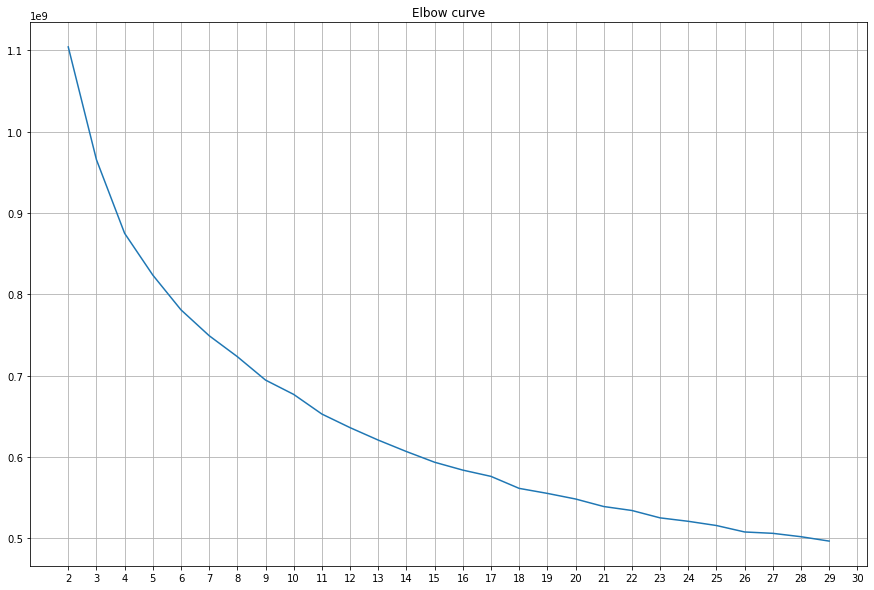

In [18]:
fig = plt.figure(figsize=(15, 10))
plt.plot(range(2, 30), distorsions)
plt.grid(True)
plt.xticks(np.arange(2, 31, 1.0))
plt.title('Elbow curve')

In [19]:

X_train, X_test, _, _ = train_test_split(new_features, new_features, test_size = 0.2, random_state = 2)

scores = []
means = []
for k in tqdm.tqdm(range(2, 30)):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    means.append(kmeans)
    scores.append(kmeans.score(X_test))
    # Sum of squared distances of samples to their closest cluster center, 
    # weighted by the sample weights if provided.

 46%|████▋     | 13/28 [00:52<01:18,  5.24s/it]

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 
100%|██████████| 28/28 [02:30<00:00,  5.36s/it]


Text(0.5, 1.0, 'Elbow curve')

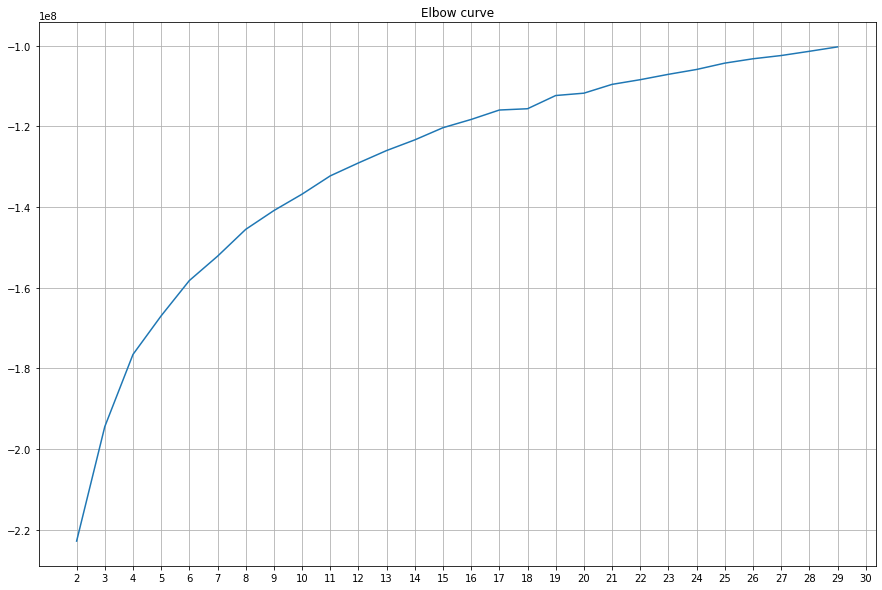

In [20]:
fig = plt.figure(figsize=(15, 10))
plt.plot(range(2, 30), scores)
plt.xticks(np.arange(2, 31, 1.0))
plt.grid(True)
plt.title('Elbow curve')

In [21]:
scores = np.array(scores)
dif_scores = scores/scores[0]
dif_scores = np.diff(dif_scores)
n_clusters = np.argwhere(dif_scores < np.quantile(dif_scores, 0.9))[-1][0]
print(n_clusters)

26


In [22]:
fans = metadata.loc[metadata['machine'] == 'fan']

In [23]:
X_train, X_test, _, _ = train_test_split(fans['mfcc'].to_list(), fans['mfcc'].to_list(), test_size = 0.2, random_state = 2)

In [24]:
scores = []
means = []
for k in tqdm.tqdm(range(2, 20)):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    means.append(kmeans)
    scores.append(kmeans.score(X_train))
    # Sum of squared distances of samples to their closest cluster center, 
    # weighted by the sample weights if provided.

100%|██████████| 18/18 [00:16<00:00,  1.12it/s]


Text(0.5, 1.0, 'Elbow curve')

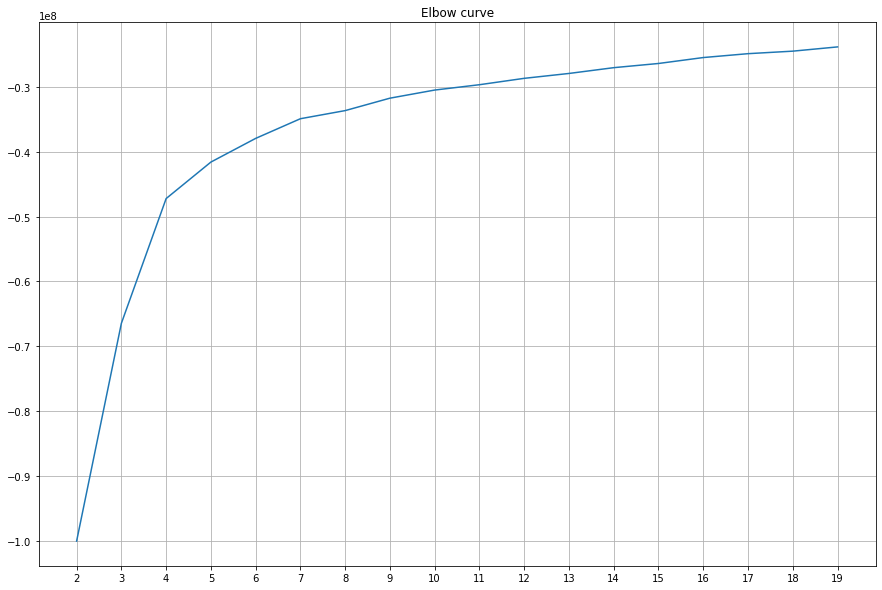

In [25]:
fig = plt.figure(figsize=(15, 10))
plt.plot(range(2, 20), scores)
plt.xticks(np.arange(2, 20, 1.0))
plt.grid(True)
plt.title('Elbow curve')

In [26]:
scores = np.array(scores)
dif_scores = scores/scores[0]
dif_scores = np.diff(dif_scores)
n_clusters = np.argwhere(dif_scores < np.quantile(dif_scores, 0.9))[-1][0]
print(n_clusters)

16


In [80]:
anomalies = metadata.loc[metadata['anomaly'] == '1']

In [92]:
anom_1 = anomalies.loc[anomalies['model'] == '0']
anom_2 = anomalies.loc[anomalies['model'] == '2']
anom_3 = anomalies.loc[anomalies['model'] == '4']
anom_4 = anomalies.loc[anomalies['model'] == '6']

anoms = [anom_1, anom_2, anom_3, anom_4]

In [98]:
kmeans_results = [[],[],[],[]]
cluster_centers = [[],[],[],[]]
cluster_labels = [[],[],[],[]]

for idx, model in enumerate(anoms):

    # Use what would be known as the optimale amount of clusters.
    kmeans = KMeans(n_clusters=4)

    # fit the KMeans algorithm to the fan samples
    kmeans_results[idx] = kmeans.fit(model['mfcc'].to_list())

    # clusters is the mean of each feature we have that defines a cluster.
    cluster_centers[idx] = kmeans.cluster_centers_

    # cluster labels are the predictions our fitted KMeans algortihm gives.
    cluster_labels[idx] = pd.Series(kmeans.labels_, name='cluster')
    
fig = make_subplots(rows=2, cols=2)
traces = [[],[],[],[]]

for x in range(4):
    
    traces[x] = px.histogram(
        color=anoms[x]['model'], 
        x=cluster_labels[x], 
        opacity = 0.8
    )
    
fig.add_traces(list(traces[0].select_traces()), 1, 1)
fig.add_traces(list(traces[1].select_traces()), 1, 2)
fig.add_traces(list(traces[2].select_traces()), 2, 1)
fig.add_traces(list(traces[3].select_traces()), 2, 2)


In [99]:
anomalies

,file_no,machine,model,anomaly,file_name,file_rel_path,duration_s,fs_Hz,SNR_dB,mel_spect,mel_spect_db,mfcc,params,cluster
0,0,fan,0,1,00000000.wav,6_dB_fan\fan\id_00\abnormal\00000000.wav,10.0,16000,6,[[2.94704933e+01 3.18928375e+01 2.79837132e+01...,[[ 1.46938744e+01 1.50369310e+01 1.44690533e...,"[-208.120071, -213.271729, -213.559753, -216.7...","{'window': 1, 'window_length': 16000, 'overlap...",1
1,1,fan,0,1,00000001.wav,6_dB_fan\fan\id_00\abnormal\00000001.wav,10.0,16000,6,[[3.44237137e+01 3.38602562e+01 3.29321747e+01...,[[ 1.53685770e+01 1.52969027e+01 1.51762047e...,"[-223.261154, -220.828018, -222.356415, -223.6...","{'window': 1, 'window_length': 16000, 'overlap...",1
2,2,fan,0,1,00000002.wav,6_dB_fan\fan\id_00\abnormal\00000002.wav,10.0,16000,6,[[3.62981758e+01 2.98847275e+01 3.18499908e+01...,[[ 1.55988483e+01 1.47544937e+01 1.50310936e...,"[-217.511383, -218.599579, -218.860703, -217.5...","{'window': 1, 'window_length': 16000, 'overlap...",1
3,3,fan,0,1,00000003.wav,6_dB_fan\fan\id_00\abnormal\00000003.wav,10.0,16000,6,[[4.02655067e+01 3.25500336e+01 2.71259766e+01...,[[ 1.60493317e+01 1.51255140e+01 1.43338537e...,"[-238.087341, -237.121368, -238.276169, -236.8...","{'window': 1, 'window_length': 16000, 'overlap...",1
4,4,fan,0,1,00000004.wav,6_dB_fan\fan\id_00\abnormal\00000004.wav,10.0,16000,6,[[3.56241570e+01 2.60457039e+01 3.50606537e+01...,[[ 1.55174456e+01 1.41573610e+01 1.54481993e...,"[-231.348358, -228.882004, -228.026077, -225.4...","{'window': 1, 'window_length': 16000, 'overlap...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17022,17022,valve,6,1,00000115.wav,6_dB_valve\valve\id_06\abnormal\00000115.wav,10.0,16000,6,[[8.42251480e-01 1.34920907e+00 2.20665741e+00...,[[-7.45582223e-01 1.30079257e+00 3.43734932e...,"[-219.040268, -189.14711, -187.799515, -163.89...","{'window': 1, 'window_length': 16000, 'overlap...",3
17023,17023,valve,6,1,00000116.wav,6_dB_valve\valve\id_06\abnormal\00000116.wav,10.0,16000,6,[[1.01974714e+00 2.77591133e+00 1.83051860e+00...,[[ 8.49249512e-02 4.43405581e+00 2.62574148e...,"[-257.553375, -184.680679, -188.90657, -187.69...","{'window': 1, 'window_length': 16000, 'overlap...",3
17024,17024,valve,6,1,00000117.wav,6_dB_valve\valve\id_06\abnormal\00000117.wav,10.0,16000,6,[[4.39361954e+00 1.32183111e+00 1.62063444e+00...,[[ 6.4282246 1.2117597 2.0968506 0.4...,"[-162.998764, -204.898132, -195.991623, -212.7...","{'window': 1, 'window_length': 16000, 'overlap...",3
17025,17025,valve,6,1,00000118.wav,6_dB_valve\valve\id_06\abnormal\00000118.wav,10.0,16000,6,[[2.38466620e+00 1.92273343e+00 1.88538647e+00...,[[ 3.774276 2.8391907 2.754004 2.6...,"[-183.558792, -195.787567, -196.860138, -197.0...","{'window': 1, 'window_length': 16000, 'overlap...",3
